#**SHL Grammar Rating Assignment**


Mounting Google Drives to access the dataset.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Preprocessing the training audio files.

Importing the necessary packages and preprocessing the training audio and saving them in new folder.

In [6]:
import os
import librosa
import soundfile as sf
import pandas as pd
from tqdm.notebook import tqdm

# Paths
AUDIO_DIR = '/content/drive/MyDrive/Colab Notebooks/audios/train'
CSV_PATH = '/content/drive/MyDrive/Colab Notebooks/train.csv'
PROCESSED_DIR = '/content/drive/MyDrive/Colab Notebooks/processed_audio'
os.makedirs(PROCESSED_DIR, exist_ok=True)

train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/train.csv')
train_df.columns = ['filename', 'label']

def preprocess_audio(file_path, save_path, sr=16000):
    y, orig_sr = librosa.load(file_path, sr=None)
    if orig_sr != sr:
        y = librosa.resample(y, orig_sr, sr)
    y = y / max(abs(y))
    y, _ = librosa.effects.trim(y, top_db=25)  #Silence Trimming
    sf.write(save_path, y, sr)

# Preprocessing each audio
for filename in tqdm(train_df['filename']):
    in_path = os.path.join(AUDIO_DIR, filename)
    out_path = os.path.join(PROCESSED_DIR, filename)
    preprocess_audio(in_path, out_path)

print("✅ Audio preprocessing completed. Files saved in:", PROCESSED_DIR)

  0%|          | 0/444 [00:00<?, ?it/s]

✅ Audio preprocessing completed. Files saved in: /content/drive/MyDrive/Colab Notebooks/processed_audio


Verifying the Preprocessed audio files.

In [7]:
files = os.listdir('/content/drive/MyDrive/Colab Notebooks/processed_audio')
print(f"🔎 Found {len(files)} preprocessed audio files.\nExample files:\n", files[:5])

# Checking sample rate and duration of a random file
sample_file = os.path.join('/content/drive/MyDrive/Colab Notebooks/processed_audio', files[0])
y, sr = librosa.load(sample_file, sr=None)

duration = librosa.get_duration(y=y, sr=sr)
print(f"📁 Sample file: {files[0]}")
print(f"🕒 Duration: {duration:.2f} seconds")
print(f"🎧 Sample rate: {sr} Hz")

🔎 Found 444 preprocessed audio files.
Example files:
 ['audio_713.wav', 'audio_845.wav', 'audio_710.wav', 'audio_946.wav', 'audio_1127.wav']
📁 Sample file: audio_713.wav
🕒 Duration: 16.64 seconds
🎧 Sample rate: 16000 Hz


Importing NLP Package and also making sure it is using GPU Engine.

In [8]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"🖥️ Using device: {device}")

🖥️ Using device: cuda


Installing OpenAI's Whisper Package for trascripting the audio files

In [4]:
!pip install git+https://github.com/openai/whisper.git

  Cloning https://github.com/openai/whisper.git to /tmp/pip-req-build-4if3zs3z
  Running command git clone --filter=blob:none --quiet https://github.com/openai/whisper.git /tmp/pip-req-build-4if3zs3z
  Resolved https://github.com/openai/whisper.git to commit 517a43ecd132a2089d85f4ebc044728a71d49f6e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 119.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 97.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 67.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━

Transcripting the audio files and exporting a CSV file of transcripts.

In [3]:
train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/train.csv')
train_df.columns = ['filename', 'label']

In [4]:
import whisper
from tqdm.notebook import tqdm
import pandas as pd
import os


# Loading Whisper ASR model
model = whisper.load_model("base")

# Transcribing and collecting text
transcripts = []

for fname in tqdm(train_df['filename']):
    audio_path = os.path.join('/content/drive/MyDrive/Colab Notebooks/processed_audio', fname)
    result = model.transcribe(audio_path, language='en')
    transcripts.append(result['text'])

# Adding transcripts to dataframe
train_df['transcript'] = transcripts

# Saving updated CSV
train_df.to_csv('/content/drive/MyDrive/Colab Notebooks/temp_storage/train_with_transcripts.csv', index=False)
print("✅ Transcriptions saved to: /content/drive/MyDrive/Colab Notebooks/temp_storage/train_with_transcripts.csv")


  0%|          | 0/444 [00:00<?, ?it/s]

✅ Transcriptions saved to: /content/drive/MyDrive/Colab Notebooks/temp_storage/train_with_transcripts.csv


Verifying the Transcripts CSV file.

In [6]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/temp_storage/train_with_transcripts.csv')
print("🧾 Columns:", df.columns.tolist())
print("✅ Total records:", len(df))
print("🗣 Sample transcript:\n")
print(df[['filename', 'label', 'transcript']].head(3))

🧾 Columns: ['filename', 'label', 'transcript']
✅ Total records: 444
🗣 Sample transcript:

         filename  label                                         transcript
0   audio_710.wav    1.0   hey thats lucky on there duns on these days t...
1  audio_1265.wav    1.0   My favorite hobby is cultivation of plants su...
2  audio_1114.wav    1.5   My goal is to become an electrical employee a...


Checking for empty transcript of any audio.

In [7]:
empty_transcripts = df['transcript'].str.strip().eq('').sum()
print(f"⚠️ Empty transcripts found: {empty_transcripts}")

⚠️ Empty transcripts found: 0


Importing regular expression package to remove amiguity present in audio transcripts like "uh", "like", "you know" etc.

In [8]:
import re

# Ambuiguious filters
FILLERS = ['uh', 'um', 'erm', 'you know', 'like', 'i mean', 'hmm', 'ah', 'uhh', 'huh', 'duh', 'ohh', 'oh']

def clean_transcript(text):
    text = text.lower()
    text = re.sub(r'\b(?:' + '|'.join(FILLERS) + r')\b', '', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'\s([?.!,"])', r'\1', text)
    text = text.strip()
    return text

# Loading previous data
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/temp_storage/train_with_transcripts.csv')

# Cleaning all transcripts
df['cleaned_transcript'] = df['transcript'].astype(str).apply(clean_transcript)

# Saving new version
df.to_csv('/content/drive/MyDrive/Colab Notebooks/temp_storage/train_cleaned.csv', index=False)
print("✅ Cleaned transcripts saved to: /content/drive/MyDrive/Colab Notebooks/temp_storage/train_cleaned.csv")


✅ Cleaned transcripts saved to: /content/drive/MyDrive/Colab Notebooks/temp_storage/train_cleaned.csv


Sample Output for Cleaned Transcript.

In [9]:
print(df[['transcript', 'cleaned_transcript']].sample(3))

                                            transcript  \
342   I'm here. I'm sure I'll have a way to try to ...   
273   My current goal in life is to become a pretty...   
120   In the bestling market, a symphony of voices ...   

                                    cleaned_transcript  
342  i'm here. i'm sure i'll have a way to try to m...  
273  my current goal in life is to become a pretty ...  
120  in the bestling market, a symphony of voices f...  


##Feature Extraction on Training Data

Grammar Feature Extraction for training data

In [18]:
import language_tool_python
import spacy
from tqdm.notebook import tqdm

# Grammar checker and NLP parser
tool = language_tool_python.LanguageTool('en-US')
nlp = spacy.load("en_core_web_sm")

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/temp_storage/train_cleaned.csv')

# Feature addition lists
error_counts = []
avg_sent_lengths = []
pos_diversities = []

for text in tqdm(df['cleaned_transcript']):
    if pd.isna(text) or not isinstance(text, str) or text.strip() == "":
        error_counts.append(0)
        avg_sent_lengths.append(0)
        pos_diversities.append(0)
        continue

    matches = tool.check(text)
    error_counts.append(len(matches))

    doc = nlp(text)
    sent_lengths = [len(sent) for sent in doc.sents]
    pos_tags = [token.pos_ for token in doc if token.pos_ != 'SPACE']

    avg_sent_lengths.append(sum(sent_lengths) / len(sent_lengths) if sent_lengths else 0)
    pos_diversities.append(len(set(pos_tags)))

# Appending new features
df['grammar_errors'] = error_counts
df['avg_sentence_length'] = avg_sent_lengths
df['pos_diversity'] = pos_diversities

# Saving the new file
df.to_csv('/content/drive/MyDrive/Colab Notebooks/temp_storage/train_features.csv', index=False)
print("✅ Grammar features saved to: /content/drive/MyDrive/Colab Notebooks/temp_storage/train_features.csv")

  0%|          | 0/444 [00:00<?, ?it/s]

✅ Grammar features saved to: /content/drive/MyDrive/Colab Notebooks/temp_storage/train_features.csv


Adding more features to dataset

In [22]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/temp_storage/train_features.csv')

df['word_count'] = df['cleaned_transcript'].apply(lambda x: len(str(x).split()))

df['grammar_errors_per_word'] = df['grammar_errors'] / df['word_count'].replace(0, 1)

df.to_csv('/content/drive/MyDrive/Colab Notebooks/temp_storage/train_features_enhanced.csv', index=False)
print("Added word_count and grammar_errors_per_word as features")


Added word_count and grammar_errors_per_word as features


Installing Transformer Package for Grammmar Error feature addition.

In [23]:
!pip install happytransformer

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.4/324.4 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.6/177.6 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 20.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: accelerate
    Found existing installation: accelerate 1.6.0
    Uninstalling accelerate-1.6.0:
      Successfully uninstalled accelerate-1.6.0
ERROR: pip's dependency resolver doe

Adding the GEC features to final ML model dataset.

In [24]:
from happytransformer import HappyTextToText, TTSettings
import pandas as pd
from tqdm.notebook import tqdm

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/temp_storage/train_cleaned.csv')
texts = df['cleaned_transcript'].astype(str).tolist()

happy_tt = HappyTextToText("T5", "vennify/t5-base-grammar-correction")
args = TTSettings(num_beams=5, min_length=1)

edit_counts = []
edit_ratios = []

for text in tqdm(texts):
    result = happy_tt.generate_text("grammar: " + text, args=args)
    corrected = result.text

    original_words = text.split()
    corrected_words = corrected.split()
    edits = sum(1 for o, c in zip(original_words, corrected_words) if o != c)
    edits += abs(len(original_words) - len(corrected_words))

    edit_counts.append(edits)
    edit_ratios.append(edits / max(1, len(original_words)))

# Adding new features to dataframe
df['gec_edits'] = edit_counts
df['gec_edit_rate'] = edit_ratios

# Saving the updated CSV file
df.to_csv('/content/drive/MyDrive/Colab Notebooks/temp_storage/train_gec_features.csv', index=False)
print("GEC features saved to /content/drive/MyDrive/Colab Notebooks/temp_storage/train_gec_features.csv")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/892M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.79k [00:00<?, ?B/s]

  0%|          | 0/444 [00:00<?, ?it/s]

Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


GEC features saved to /content/drive/MyDrive/Colab Notebooks/temp_storage/train_gec_features.csv


Snippet of the earlier features incorporated into dataset.

In [25]:
archis=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/temp_storage/train_features.csv')
archis

,filename,label,transcript,cleaned_transcript,grammar_errors,avg_sentence_length,pos_diversity
0,audio_710.wav,1.0,hey thats lucky on there duns on these days t...,hey thats lucky on there duns on these days th...,7,21.000000,14
1,audio_1265.wav,1.0,My favorite hobby is cultivation of plants su...,my favorite hobby is cultivation of plants suc...,3,16.500000,10
2,audio_1114.wav,1.5,My goal is to become an electrical employee a...,my goal is to become an electrical employee an...,3,47.000000,11
3,audio_946.wav,1.5,the playground looks like very clear and neat...,the playground looks very clear and neat as th...,1,20.000000,10
4,audio_1127.wav,2.0,My goal is to bring my parents to live with m...,my goal is to bring my parents to live with me...,15,12.181818,12
...,...,...,...,...,...,...,...
439,audio_613.wav,5.0,NaN,NaN,0,0.000000,0
440,audio_1002.wav,5.0,"In the backdrop of a school, you might see Va...","in the backdrop of a school, you might see vas...",14,14.100000,12
441,audio_1058.wav,5.0,"My favorite place to visit is Palm Springs, C...","my favorite place to visit is palm springs, ca...",14,19.857143,14
442,audio_250.wav,5.0,One of my favorite hobbies is to repurpose cl...,one of my favorite hobbies is to repurpose clo...,12,17.250000,13


Combining of the earlier engineered general feature and GEC features into final dataset ready for ML model training.

In [28]:
import pandas as pd

df_main = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/temp_storage/train_features_enhanced.csv')
df_gec = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/temp_storage/train_gec_features.csv')

df_combined = df_main.copy()
df_combined['gec_edits'] = df_gec['gec_edits']
df_combined['gec_edit_rate'] = df_gec['gec_edit_rate']

df_combined.to_csv('/content/drive/MyDrive/Colab Notebooks/temp_storage/train_all_features.csv', index=False)
print("✅ Combined feature set saved.")

✅ Combined feature set saved.


###ML Model Training

Applying various Machine Learning Algorithms.

In [30]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/temp_storage/train_all_features.csv')

df = df.dropna(subset=['label'])

feature_cols = [
    'grammar_errors',
    'avg_sentence_length',
    'pos_diversity',
    'word_count',
    'grammar_errors_per_word',
    'gec_edits',
    'gec_edit_rate'
]
X = df[feature_cols]
y = df['label']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

models = {
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=0.1),
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42, verbosity=0),
    'LightGBM': lgb.LGBMRegressor(n_estimators=100, random_state=42)
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, preds))
    corr, _ = pearsonr(y_val, preds)
    results[name] = {'RMSE': rmse, 'Pearson': corr}
    print(f"{name} -> RMSE: {rmse:.4f}, Pearson: {corr:.4f}")

best_model = max(results.items(), key=lambda x: x[1]['Pearson'])
print(f"\n✅ Best model: {best_model[0]} with Pearson correlation: {best_model[1]['Pearson']:.4f}")

Ridge -> RMSE: 1.1489, Pearson: 0.2002
Lasso -> RMSE: 1.1716, Pearson: 0.0907
RandomForest -> RMSE: 1.1212, Pearson: 0.3042
GradientBoosting -> RMSE: 1.1188, Pearson: 0.3167
XGBoost -> RMSE: 1.1733, Pearson: 0.2722
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000225 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 528
[LightGBM] [Info] Number of data points in the train set: 355, number of used features: 7
[LightGBM] [Info] Start training from score 4.001408
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Best Model was GradientBoosting with Pearson Correlation of 0.3167. Hence training the Model with GradientBoosting with better hyper parametering to get refined Pearson Correlation value.

In [38]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
import numpy as np


param_grid = {
    'n_estimators': [50, 100, 200],  # Number of boosting stages (trees)
    'learning_rate': [0.01, 0.05, 0.1],  # Step size shrinking
    'max_depth': [3, 5, 7],  # Depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
    'subsample': [0.8, 0.9, 1.0],  # Fraction of samples used for fitting each tree
    'max_features': [None, 'sqrt', 'log2']  # Number of features to consider at each split
}

gb_model = GradientBoostingRegressor(random_state=42)

grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error', verbose=1)

grid_search.fit(X_train, y_train)

print(f"Best parameters found: {grid_search.best_params_}")

y_pred = grid_search.best_estimator_.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
pearson_corr, _ = pearsonr(y_test, y_pred)

print(f"Optimized GradientBoosting -> RMSE: {rmse:.4f}, Pearson: {pearson_corr:.4f}")


Fitting 5 folds for each of 729 candidates, totalling 3645 fits
Best parameters found: {'learning_rate': 0.01, 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 100, 'subsample': 1.0}
Optimized GradientBoosting -> RMSE: 1.1242, Pearson: 0.3013


##Pre-Processing the test audio files.

Following same procedure as train audio files. Preprocessing the test audio files.

In [45]:
import os
import librosa
import soundfile as sf
import pandas as pd
from tqdm import tqdm

TEST_AUDIO_DIR = '/content/drive/MyDrive/Colab Notebooks/audios/test'
TEST_CSV_PATH = '/content/drive/MyDrive/Colab Notebooks/test.csv'
TEST_PROCESSED_DIR = '/content/drive/MyDrive/Colab Notebooks/processed_audio_test'
os.makedirs(TEST_PROCESSED_DIR, exist_ok=True)

test_df = pd.read_csv(TEST_CSV_PATH)

def preprocess_audio(file_path, save_path, sr=16000):
    y, orig_sr = librosa.load(file_path, sr=None)
    if orig_sr != sr:
        y = librosa.resample(y, orig_sr, sr)
    y = y / max(abs(y))
    y, _ = librosa.effects.trim(y, top_db=25)
    sf.write(save_path, y, sr)

for filename in tqdm(test_df['filename']):
    in_path = os.path.join(TEST_AUDIO_DIR, filename)
    out_path = os.path.join(TEST_PROCESSED_DIR, filename)
    preprocess_audio(in_path, out_path)


100%|██████████| 204/204 [00:35<00:00,  5.80it/s]


Transcripting the Test Audio files.

In [47]:
import whisper

model_whisper = whisper.load_model("base")
transcripts = []

for fname in tqdm(test_df['filename']):
    audio_path = os.path.join(TEST_PROCESSED_DIR, fname)
    result = model_whisper.transcribe(audio_path, language='en')
    transcripts.append(result['text'])

test_df['transcript'] = transcripts

100%|██████████| 204/204 [12:14<00:00,  3.60s/it]


Removing ambiguity in transcript of test audio files.

In [48]:
import re

FILLERS = ['uh', 'um', 'erm', 'you know', 'like', 'i mean', 'hmm', 'ah', 'uhh', 'huh']

def clean_transcript(text):
    text = text.lower()
    text = re.sub(r'\b(?:' + '|'.join(FILLERS) + r')\b', '', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'\s([?.!,"])', r'\1', text)
    return text.strip()

test_df['cleaned_transcript'] = test_df['transcript'].apply(clean_transcript)

test_df.to_csv('/content/drive/MyDrive/Colab Notebooks/temp_storage/test_cleaned.csv', index=False)
print("Cleaned test transcripts saved.")


Cleaned test transcripts saved.


Test Data Feature Extraction

In [49]:
import language_tool_python
import spacy
from happytransformer import HappyTextToText, TTSettings

tool = language_tool_python.LanguageTool('en-US')
nlp = spacy.load("en_core_web_sm")
happy_tt = HappyTextToText("T5", "vennify/t5-base-grammar-correction")
args = TTSettings(num_beams=5, min_length=1)

error_counts = []
avg_sent_lengths = []
pos_diversities = []
gec_edits = []
gec_rates = []
word_counts = []

for text in tqdm(test_df['cleaned_transcript']):
    matches = tool.check(text)
    error_counts.append(len(matches))

    doc = nlp(text)
    sent_lens = [len(sent) for sent in doc.sents]
    pos_tags = [token.pos_ for token in doc if token.pos_ != 'SPACE']
    avg_sent_lengths.append(sum(sent_lens) / len(sent_lens) if sent_lens else 0)
    pos_diversities.append(len(set(pos_tags)))

    words = text.split()
    word_counts.append(len(words))

    corrected = happy_tt.generate_text("grammar: " + text, args=args).text
    edits = sum(1 for o, c in zip(words, corrected.split()) if o != c)
    edits += abs(len(words) - len(corrected.split()))
    gec_edits.append(edits)
    gec_rates.append(edits / max(1, len(words)))

# Adding the same features as train dataset features
test_df['grammar_errors'] = error_counts
test_df['avg_sentence_length'] = avg_sent_lengths
test_df['pos_diversity'] = pos_diversities
test_df['word_count'] = word_counts
test_df['grammar_errors_per_word'] = test_df['grammar_errors'] / test_df['word_count'].replace(0, 1)
test_df['gec_edits'] = gec_edits
test_df['gec_edit_rate'] = gec_rates

test_df.to_csv('/content/drive/MyDrive/Colab Notebooks/temp_storage/test_cleaned.csv', index=False)
print("✅ Updated test_cleaned.csv with new features.")

100%|██████████| 204/204 [05:16<00:00,  1.55s/it]

✅ Updated test_cleaned.csv with new features.


Testing the test data on the trained ML model and saving the result into submission.csv file.

In [50]:
import pandas as pd
import numpy as np

test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/temp_storage/test_cleaned.csv')

test_features = test_df[['grammar_errors', 'avg_sentence_length', 'pos_diversity',
                         'word_count', 'grammar_errors_per_word', 'gec_edits', 'gec_edit_rate']]

y_pred = best_gb.predict(test_features)

y_pred_rounded = np.round(y_pred).astype(int)

submission_df = pd.DataFrame({
    'filename': test_df['filename'],
    'label': y_pred_rounded
    })

submission_df.to_csv('/content/drive/MyDrive/Colab Notebooks/submission.csv', index=False)

print("Submission file created: submission.csv")


Submission file created: submission.csv


##Final Outcome

Best Pearson Correlation Score achieved with GradientBoosting Model with value of 0.3167 which is almost producing correct grammatical labelling.

Future ML Pipeline->
  Adding more features into dataset using more efficient NLP libraries and perform better Hyper Parametering.

Exporting the Model for future use.

In [51]:
import joblib

joblib.dump(best_gb, '/content/drive/MyDrive/Colab Notebooks/best_gradient_boosting_model.pkl')

print("Model saved as best_gradient_boosting_model.pkl")

Model saved as best_gradient_boosting_model.pkl


##Some Visualization to understand the Model better

Feature Importance using BarPlot

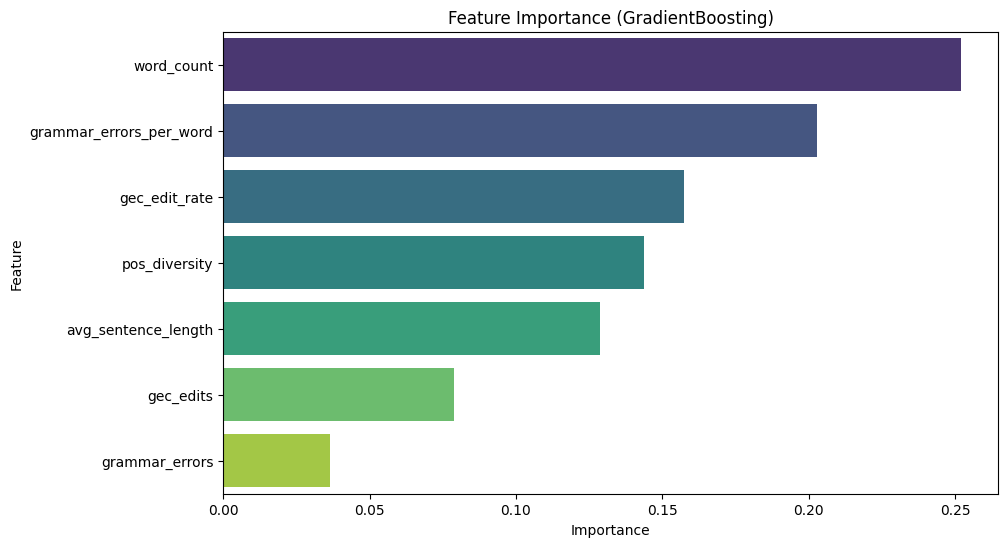

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
feature_importances = best_gb.feature_importances_
features = ['grammar_errors', 'avg_sentence_length', 'pos_diversity',
            'word_count', 'grammar_errors_per_word', 'gec_edits', 'gec_edit_rate']

feature_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
})

feature_df = feature_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_df, palette='viridis')
plt.title('Feature Importance (GradientBoosting)')
plt.show()

Model Prediction Histographical Plot

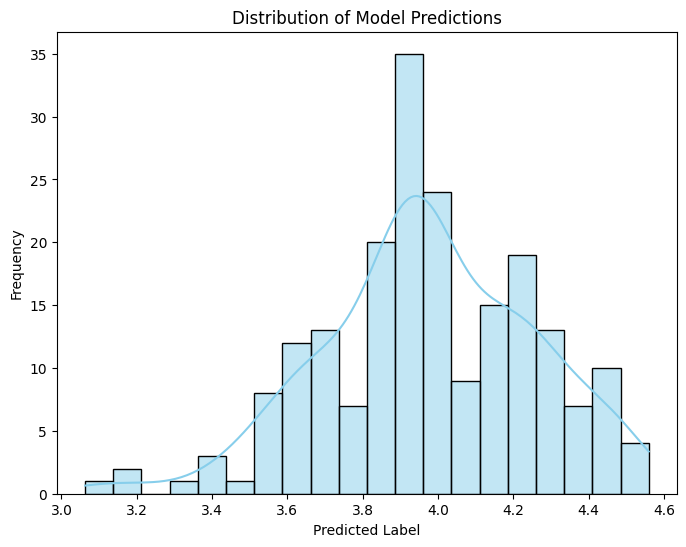

In [54]:
plt.figure(figsize=(8, 6))
sns.histplot(y_pred, bins=20, kde=True, color='skyblue')
plt.title('Distribution of Model Predictions')
plt.xlabel('Predicted Label')
plt.ylabel('Frequency')
plt.show()

RMSE vs Pearson Correlation Comparsion

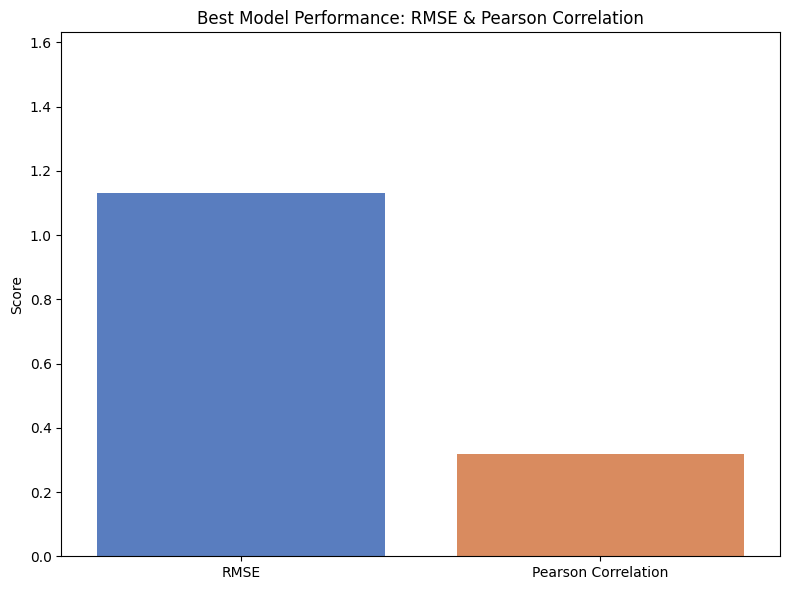

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

# Best model scores
rmse_best = 1.1311
pearson_best = 0.3176

plt.figure(figsize=(8, 6))
sns.barplot(x=['RMSE', 'Pearson Correlation'], y=[rmse_best, pearson_best], palette='muted')
plt.title('Best Model Performance: RMSE & Pearson Correlation')
plt.ylabel('Score')
plt.ylim(0, max(rmse_best, pearson_best) + 0.5)  # Adjust y-axis for clarity
plt.tight_layout()
plt.show()


Correlation Matrix

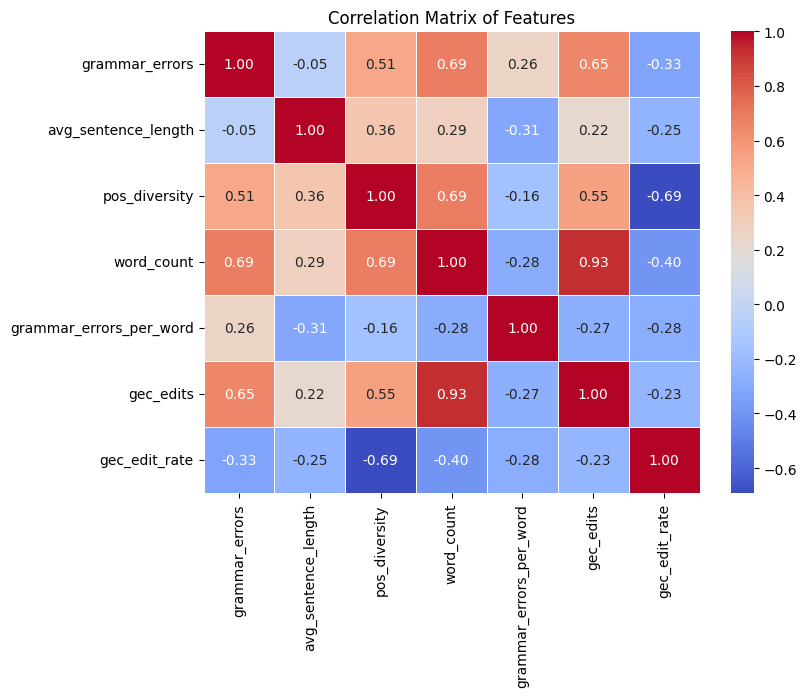

In [63]:
corr_matrix = test_df[['grammar_errors', 'avg_sentence_length', 'pos_diversity',
                       'word_count', 'grammar_errors_per_word', 'gec_edits', 'gec_edit_rate']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Features')
plt.show()